In [1]:
from utils import *
from main import run_experiment
from environments.harmonic_oscillator import HarmonicOscillator
import numpy as np
import matplotlib.pyplot as plt
import jax.random as jr
import jax.numpy as jnp
import jax
import os

os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10'

device = jax.devices()[0].platform
print(f"Using device: {device}")

These device(s) are detected:  [CpuDevice(id=0)]
Using device: cpu


In [2]:
def distance_reward(t, x, target):
    return -jnp.abs(target - x[0])


def directional_reward(t, x, target):
    return target - x[0]


args = {
    "param_setting": "constant",
    "batch_size": 8,
    "n_obs": 2,
    "process_noise": 0.05,
    "obs_noise": 0.1,
    "num_generations": 50,
    "population_size": 100,
    "num_populations": 10
}

save_path = 'results/harmonic_oscillator/full_obs/direct_target'
os.makedirs(save_path, exist_ok=True)

In [3]:
strategy, best_fitnesses = run_experiment(args, reward_fn=None, save_path=save_path, device=device)

Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'tar'].
Compiling code for evaluation and evolution...
Finished compilation in 52.15 seconds
In generation 1
Complexity: 5, fitness: 5.642728328704834, equations: [-0.382, -0.332*a1, 0.594]
Complexity: 7, fitness: 5.629879951477051, equations: [0.342, y1 + 0.245, 0.0707]
Complexity: 9, fitness: 3.7295005321502686, equations: [-0.588, 0.0934, 0.795*tar - 0.526]
Complexity: 17, fitness: 3.6581690311431885, equations: [a0 + 0.0695, 2.02*y0 - 0.482, 0.567*tar - 0.333]
Complexity: 19, fitness: 0.5594930648803711, equations: [-0.849*a0 - y0**2*y1, u0*(u0 + 1.13), 0.453*a0 + tar]
In generation 2
Complexity: 3, fitness: 4.055759906768799, equations: [0.107, -0.0532, tar]
Complexity: 9, fitness: 3.7295005321502686, equations: [-0.588, 0.0934, 0.795*tar - 0.526]
Complexity: 11, fitness: 3.582249879837036, equations: [1.40, 0.469, 0.795*tar - 0.309]
Complexity: 13, fitness: 3.558077096939087, equations: [tar + 1.2, 2.08, 0.616*tar 

In [4]:
# Get the best solution from the pareto front
best_idx = jnp.argmin(jnp.array(strategy.pareto_front[0]))
best_fitness = strategy.pareto_front[0][best_idx]  # Best fitness
best_solution = strategy.pareto_front[1][best_idx]  # Best solution
best_solution_str = strategy.expression_to_string(best_solution)

print(f"Final best fitness: {best_fitness}")
print(f"Final best solution: {best_solution_str}")

os.makedirs(save_path, exist_ok=True)
np.save(f'{save_path}/best_fitnesses.npy', best_fitnesses)
np.save(f'{save_path}/best_solutions.npy', strategy.pareto_front[1])

Final best fitness: 0.2676236927509308
Final best solution: [-3*tar + 3*u0 + 2*y1, -1.85, -a0 + tar + 0.481]


In [3]:
env = HarmonicOscillator(process_noise=args["process_noise"], obs_noise=args["obs_noise"])
test_data = get_data(jr.PRNGKey(10), env, 4, 0.2, 40.0, args["param_setting"], dynamic_target=True)
x0s, ts, targets, noise_key, params = test_data
operator_list = [
    ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
    ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
    ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
]
strategy, fitness_function = get_strategy(env, operator_list, 0.05, reward_fn=None, device=device)
best_fitness, best_model = validate(np.load(f'{save_path}/best_solutions.npy'), strategy, test_data)
print(f"Best fitness on test data: {best_fitness}")

Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'tar'].
Best fitness on test data: 0.4076716899871826


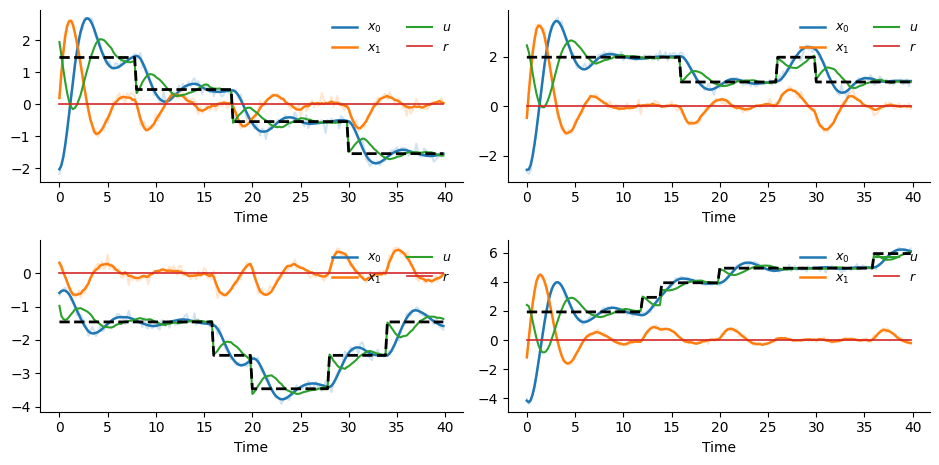

In [4]:
xs, ys, us, activities, fitness, rs = jax.vmap(fitness_function.evaluate_trajectory, in_axes=[
    None, 0, None, 0, 0, 0, None])(best_model, *test_data, strategy.tree_evaluator)

fig, ax = plt.subplots(2, 2, figsize=(9.5, 5))
ax = ax.ravel()
for i in range(4):
    ax[i].plot(ts, xs[i, :, 0], label="$x_0$", color="#1f77b4", linewidth=1.8)
    ax[i].plot(ts, xs[i, :, 1], label="$x_1$", color="#ff7f0e", linewidth=1.8)
    ax[i].plot(ts, ys[i, :, 0], alpha=0.2, color="#1f77b4")
    ax[i].plot(ts, ys[i, :, 1], alpha=0.2, color="#ff7f0e")
    ax[i].plot(ts, us[i, :], label="$u$", color="#2ca02c", linewidth=1.5)
    ax[i].plot(ts, rs[i, :], label="$r$", color="#d62728", linewidth=1.2)
    ax[i].plot(ts, targets[i, :, 0], '--k', lw=2)
    ax[i].set_xlabel("Time")
    ax[i].legend(loc="upper right", fontsize=9, frameon=False, ncols=2)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].autoscale_view(scalex=True, scaley=True)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()